# E-07 Human Segmentation

### 1. 셸로우 포커스 만들기
1-1. 사람 사진으로 적용.

1-2. 고양이(a) 사진으로 적용.

1-3. 다른 고양이(b) 사진으로 적용.

1-4. 고양이(b) 사진으로 크로마키.

### 2. 문제점 찾기

### 3. 해결 방법 제시

### 4. 회고

## 1. 셸로우 포커스 만들기

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


(544, 550, 3)


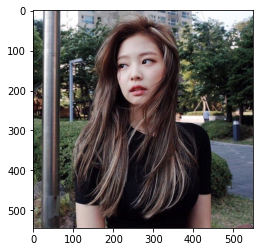

In [3]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/jen.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [27]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f712f777520>)

---
#### urllib.request.urlretrieve(url, filename=None, reporthook=None, data=None)
url의 내용을 가져와 filename에 배치.

---

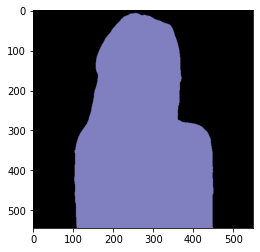

In [28]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues, output = model.segmentAsPascalvoc(img_path)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)
# person은 15

plt.imshow(output)
plt.show()

In [9]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [11]:
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

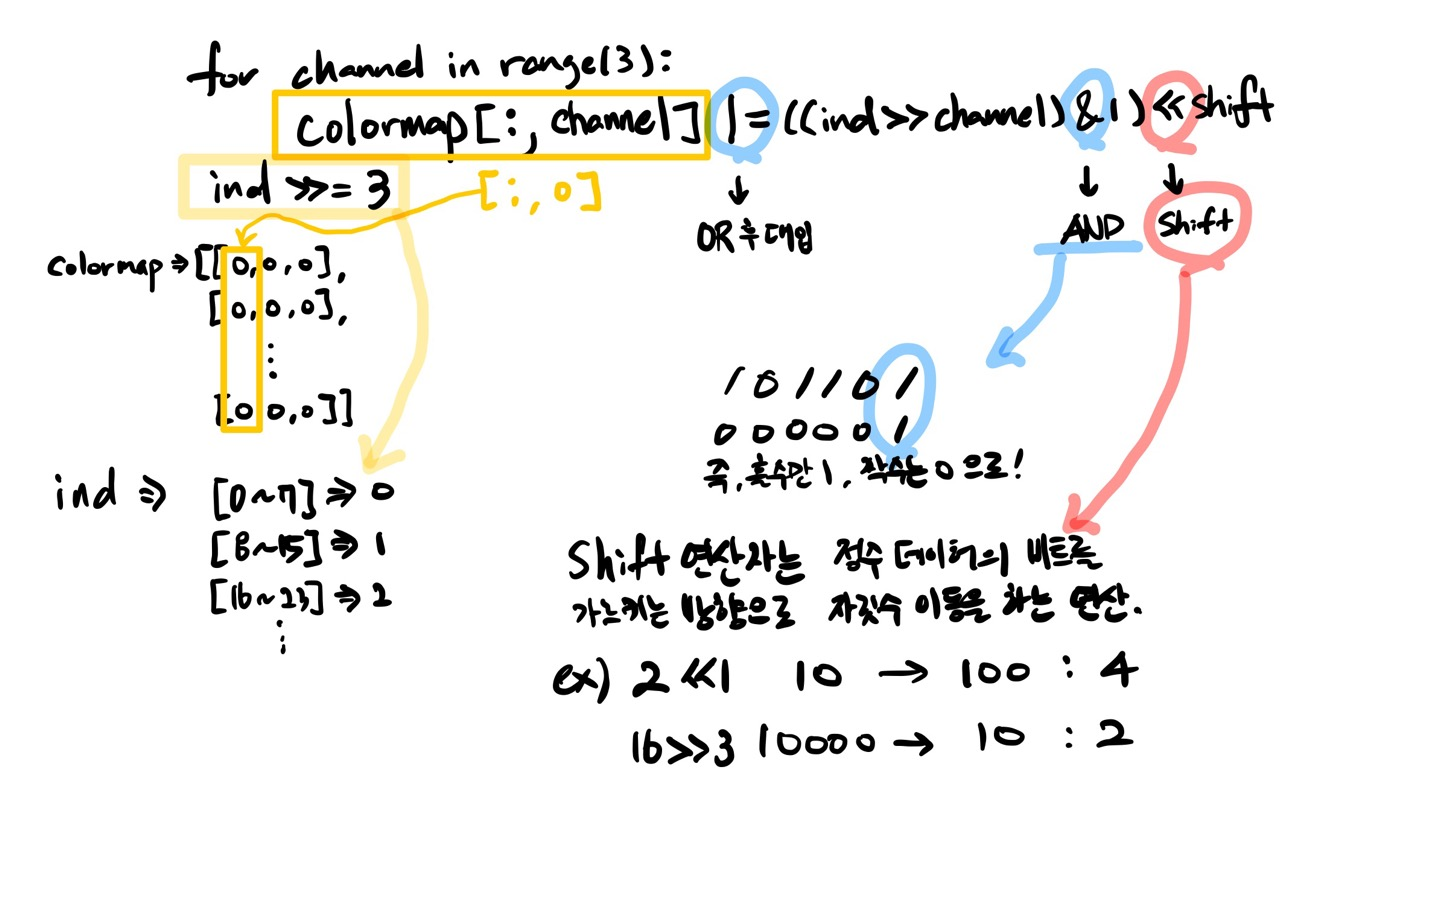

In [12]:
colormap[15] # RGB

array([192, 128, 128])

(544, 550)


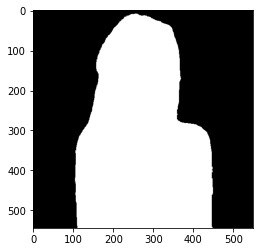

In [13]:
seg_color = (128, 128, 192)
# person에 해당하는 color(BGR로 바꿔줌.)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

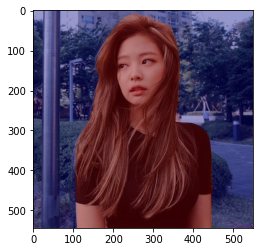

In [14]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

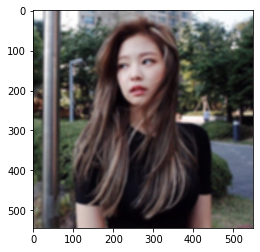

In [15]:
# (13,13)은 blurring kernel size를 뜻하는데, 값이 커질수록 blurring 효과가 짙어진다.

img_orig_blur = cv2.blur(img_orig, (8,8))   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

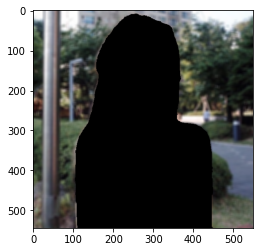

In [16]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

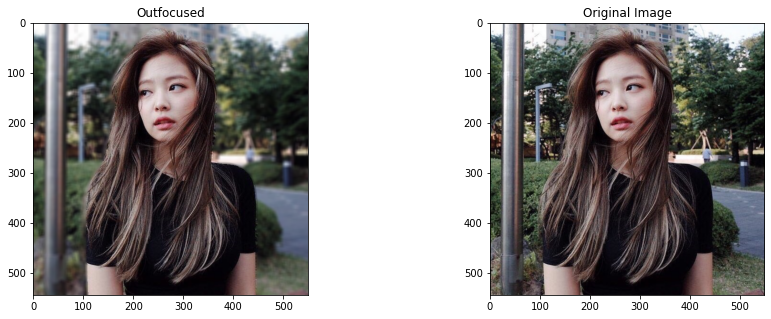

In [23]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

fig = plt.figure(figsize=(15, 5)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('Outfocused')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
ax.set_title('Original Image')

plt.show()


전체적으로 굉장히 잘 처리된 것을 볼 수 있다. 인물에 대한 누끼선 복잡하지 않고 빈틈이나 심한 곡선없이 하나의 영역으로서 segmentation하기 쉬웠을거라고 판단한다.

#### 1-2. 고양이(a) 사진으로 적용.

(656, 1000, 3)


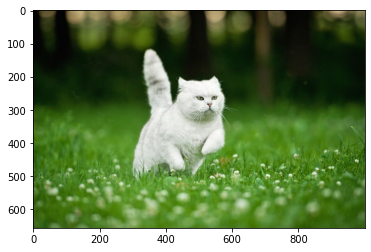

In [8]:
img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat3.jpg'  
img_orig2 = cv2.imread(img_path2) 

print(img_orig2.shape)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
plt.show()

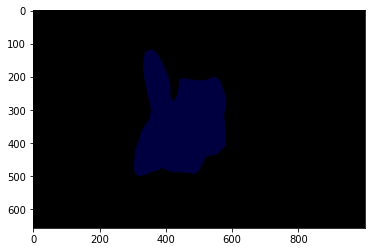

In [24]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues2, output2 = model.segmentAsPascalvoc(img_path2)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
# cat은 8 

plt.imshow(output2)
plt.show()

In [23]:
for class_id in segvalues2['class_ids']:
    print(LABEL_NAMES[class_id])

background
cat


In [25]:
colormap[8] # RGB

array([64,  0,  0])

(656, 1000)


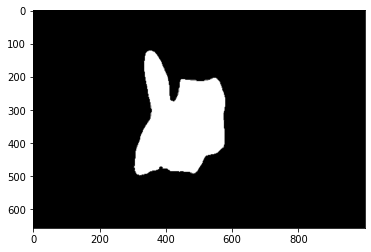

In [28]:
seg_color = (0, 0, 64)
# person에 해당하는 color(BGR로 바꿔줌.)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output2==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

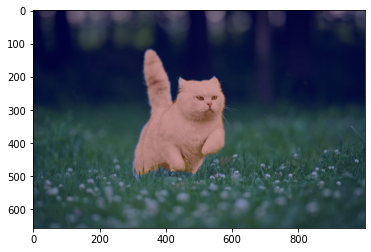

In [29]:
img_show = img_orig2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

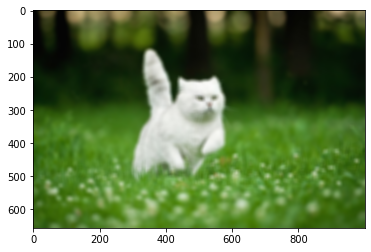

In [31]:
img_orig_blur = cv2.blur(img_orig2, (13,13))   
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

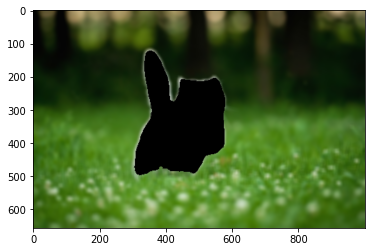

In [32]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

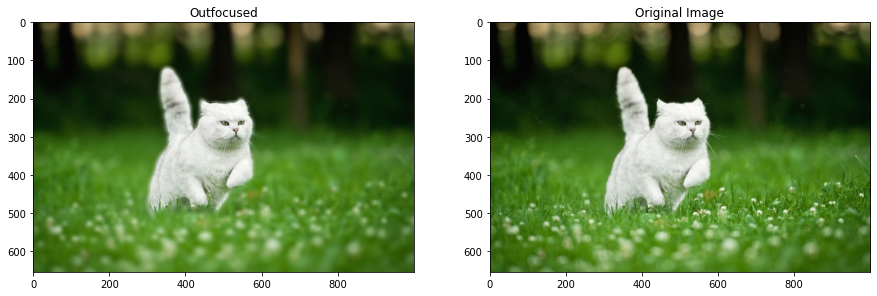

In [34]:
img_concat = np.where(img_mask_color==255, img_orig2, img_bg_blur)

fig = plt.figure(figsize=(15, 5)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('Outfocused')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig2, cv2.COLOR_BGR2RGB))
ax.set_title('Original Image')

plt.show()

#### 1-3. 다른 고양이(b) 사진으로 적용.

(560, 602, 3)


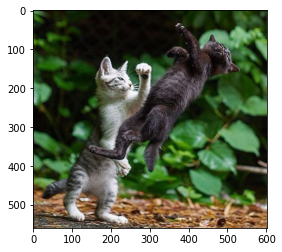

In [36]:
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/catboxer.jpg'  
img_orig3 = cv2.imread(img_path3) 

print(img_orig3.shape)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

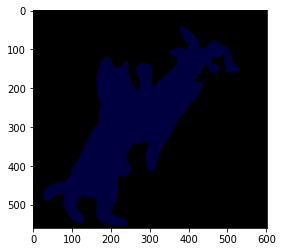

In [37]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

segvalues3, output3 = model.segmentAsPascalvoc(img_path3)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
# cat은 8 

plt.imshow(output3)
plt.show()

(560, 602)


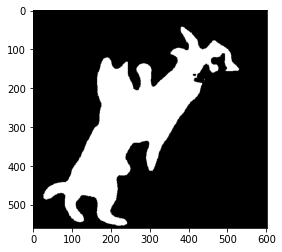

In [38]:
seg_color = (0, 0, 64)
# person에 해당하는 color(BGR로 바꿔줌.)

# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output3==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

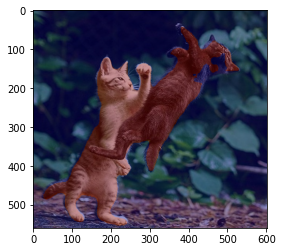

In [39]:
img_show = img_orig3.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

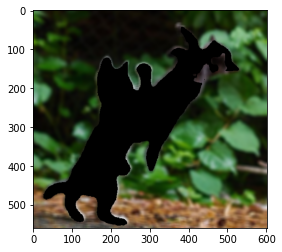

In [43]:
img_orig_blur = cv2.blur(img_orig3, (10,10))   

img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

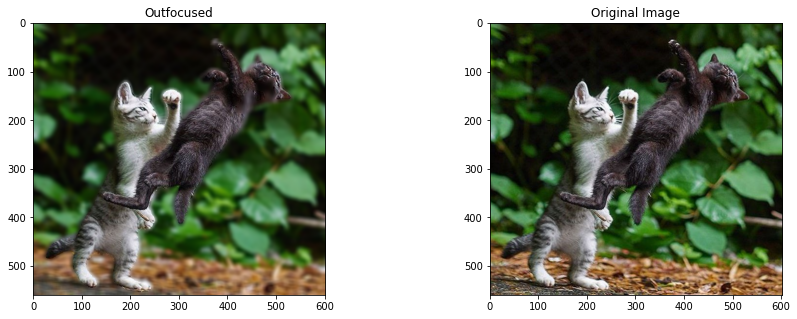

In [44]:
img_concat = np.where(img_mask_color==255, img_orig3, img_bg_blur)

fig = plt.figure(figsize=(15, 5)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
ax.set_title('Outfocused')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
ax.set_title('Original Image')

plt.show()

#### 1-4. 고양이(b) 사진으로 크로마키.

In [50]:
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg.jpg'  
img_bg = cv2.imread(img_path4) 

print(img_orig3.shape)

(560, 602, 3)


In [51]:
resize = img_orig3.shape[:2][::-1]
resized_bg = cv2.resize(img_bg, resize)
print(resized_bg.shape)

(560, 602, 3)


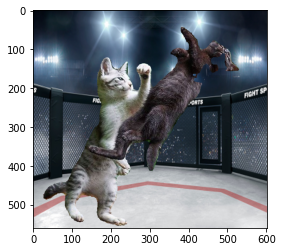

In [53]:
img_concat = np.where(img_mask_color==255, img_orig3, resized_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 2. 문제점 찾기

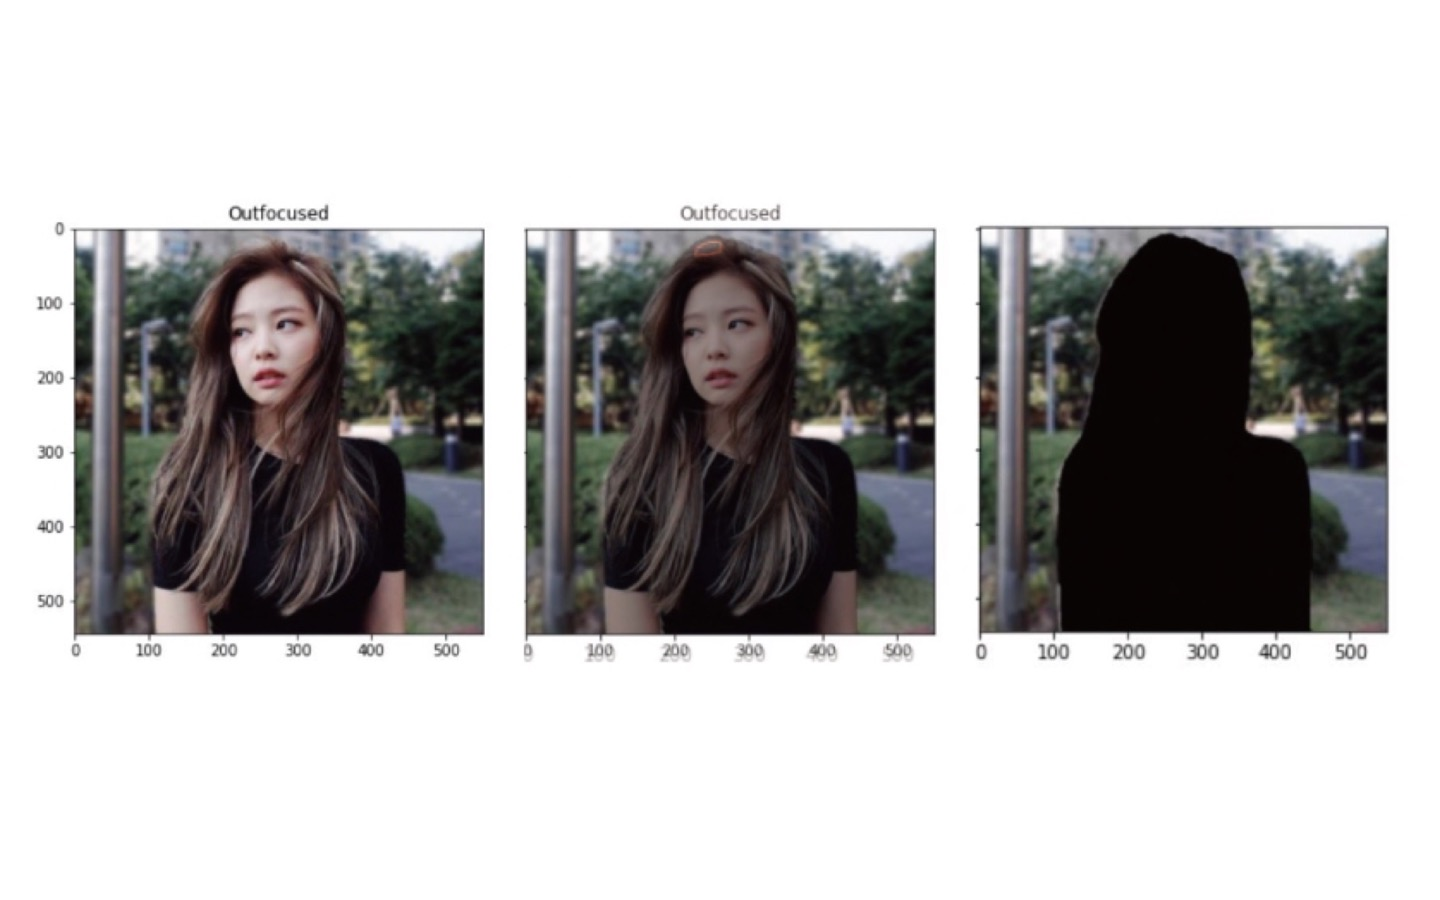

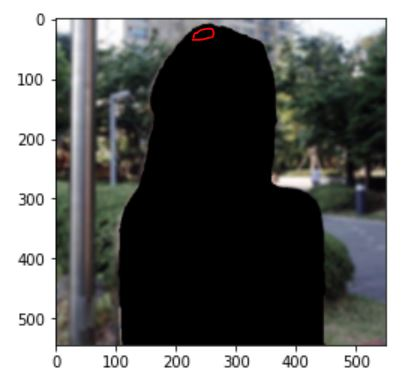

1-1 에서는 삐져나온 잔머리 안쪽으로 사람 마스크로 인식되었다. 그래서 잔머리 안쪽으로 작은 타원형 만큼은 뒷배경이 Blur처리가 되지 않았다.

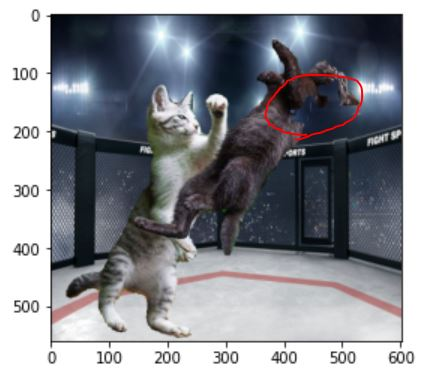

1-3 사진을 이용하여 크로마키 합성을 시도했는데 검은색 고양이는 꽤 큰 부분이 mask의 오류로 인해 소실되었다. 이 외에도 디테일하게 살펴보면 경계가 말끔하지 못하기 때문에 이전 배경에서 보이는 잎사귀 부분의 색들이 그대로 보인다.

---

## 3. 해결방법 제시

#### 모호해진 경계를 해결하는 방법
경계가 제대로 만들어지지 않아서 어색한 부분들이 발생하는 것은 대표적으로 Gaussian blur(또는 Gaussian smoothing으로도 불림)를 사용하여 경계선 쪽에 그라데이션을 주어서 자연스러운 경계를 만들어 더욱 좋은 결과를 낼 수 있다. 하지만 잘못된 Mask를 해결해주지는 못한다. 


#### Mask 성능 개선을 위한 방법
더 나은 Semantic Segmentation을 위한 방법으로 세 가지 방법을 제시하는 논문이 있어 이중 두 가지를 해결 방안으로서 제시 및 이해해보려한다.


Three Ways to Improve Semantic Segmentation with Self-Supervised Depth Estimation :
https://arxiv.org/pdf/2012.10782.pdf

- Transfer- and Multi-Task Learning
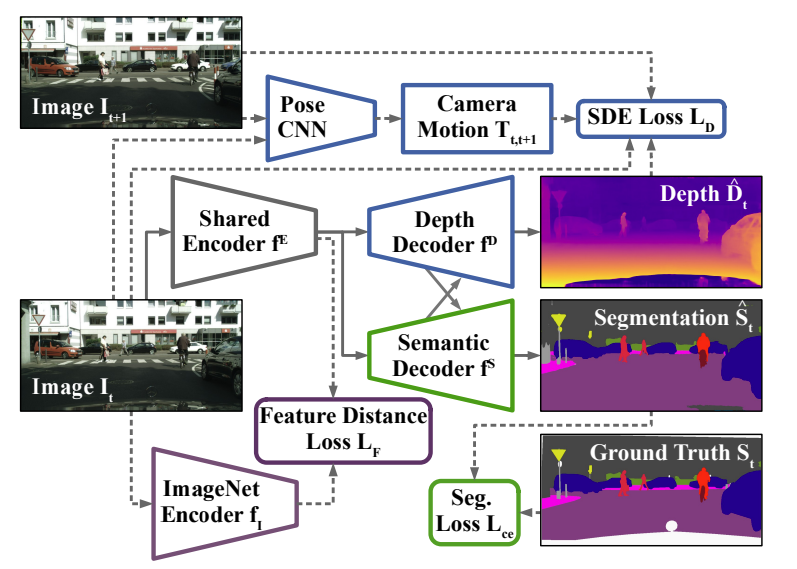

우선 네트워크를 통해 depth estimation을 학습한다. 그리고 추정된 depth값을 바탕으로 Semantic segmentation의 가중치들을 모두 초기화하여 다시 학습을 진행하는데, 이는 multi-task learning을 통해서 공동으로 학습하여 진행된다. Multi-task learning은 ML/DL이 많은 양질의 데이터를 통해 좋은 효율을 내기는 하지만 데이터 양이 적을 때는 어떻게 좋은 성능을 낼 수 있을지에 대한 고민에서 고안된 기법이다. 이전에 행했던 학습과 경험들을 현재 수행하는 새로운 학습에 접목시켜 빠르고 효율적으로 학습하는 인간의 방식에서 착안하여, 컴퓨터 또한 연관성 있는 여러가지 task들을 동시에 학습시켜서 서로 다른 task들에 좋은 영향을 주는 방식을 사용한다. 이를 통해 knowledge transfer, overfitting 감소 그리고 하나의 신경망으로 여러 task를 수행하는 효율성을 챙길 수 있었다. 물론 모든 경우에 이를 적용할 순 없지만 이번 프로젝트와 같이 낮은 수준의 feature들만 학습하고 공유하는 경우에는 매우 좋은 방식이 될 수 있다고 생각한다. 예를 들면, 자율주행을 학습할 때 신호등, 자동차, 보행자를 인식하는 task들은 표지판을 인식하는데 task와 비슷한 특성들을 가지고 있기 때문에 multi-task learning이 효과적인 학습법이 된다.

---

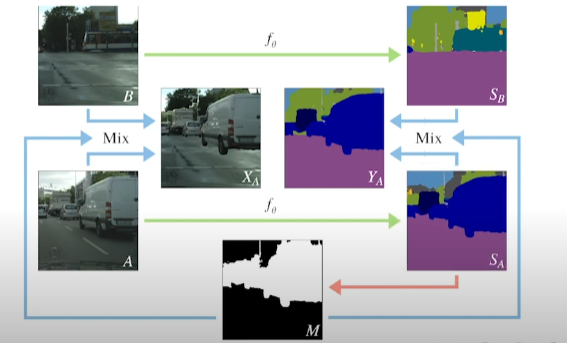


- DepthMix Data Augmentation

DepthMix를 자세하게 설명하는 마땅한 자료를 찾지 못했지만 mixup에서 기법을 이용한 하나의 data augmentation 방식 중 하나이다. Mixup 기법을 활용한 augmentation 중 가장 대표적인 것이 ClassMix인데, 작동 방식은 위 그림과 같다. 
1. A,B의 predicted segmentation Sa, Sb를 얻은 후에 Sa로 부터 절반의 class를 1 나머지는 0의 값을 갖는 mask M을 만든다.
2. 이 mask M을 기준으로 A 이미지에서는 1에 해당하는 픽셀들을 얻고, B에서는 0에 해당하는 픽셀값들을 얻는다.
3. Segmentation Sa와 Sb에서도 마찬가지로 2번과 동일한 과정을 거친다.
4. 새롭게 얻어진 이미지와 마스크로 다시 학습을 진행한다.


하지만 ClassMix는 어떤 경우에는 어떤 물체가 앞에 있는지 또는 뒤에 있는지를 구분할 수 없는 문제가 발생하고 다음 사진의 마지막 부분처럼 사람이 자동차 위로 겹치도록 mask가 생길 수가 있다. 이러한 부분들을 더욱 자연스럽게 처리하고 depth 정보를 mask에 담을 수 있기 때문에 논문에서 DepthMix라는 방법을 제시한다. DepthMix는 알고리즘에 따라 카메라로부터 더욱 가까운 부분들을 비교하고 그에 따라 Si로부터 선택한 class들의 구역만 남겨서 0,1로 이진화된 새로운 마스크를 만드는 방식으로 보여진다. 그리고 후의 방식은 ClassMix와 동일하다.
결론적으로 data augmentation을 통해 Depth 정보가 들어간 Segmentation을 더욱 다양하게 학습시키게 되므로 더 좋은 성능으로 이어질 수 있을 것으로 보인다.


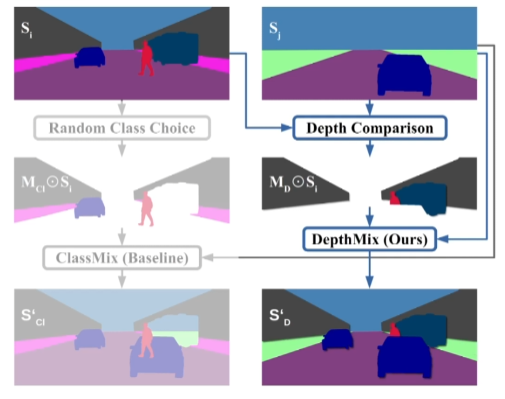

---

## 4. 회고

- Segmentation 작업을 향상시킬 수 있는 멋진 방식들을 많이 알게 되었다. 하지만 이를 직접 적용해보기에는 어려움이 있어 실제로 이번 프로젝트에서 발생하는 문제들을 개선시켜줄지 직접 확인하지 못한 점이 아쉽다.
- 여러 자료들을 찾아봤지만 절반도 이해하지 못한 기분이라 찝찝한 느낌이다.



## 5. 참고 문헌

1. [Semantic Segmentation] DeepLab v3+ 원리 : https://kuklife.tistory.com/121
2. 아이폰 인물사진 모드 따라 만들기, youtube : https://youtu.be/NRB7Mp41f64
3. DeepLab V3 이해를 위한 이정표 : https://shangom-developer.tistory.com/4
4. Three Ways to Improve Semantic Segmentation with Self-Supervised Depth Estimation에 대한 영상 :  https://www.youtube.com/watch?v=WC6LE9WQT94&ab_channel=LukasHoyer
5. Multi-task learning에 대한 블로그 : https://velog.io/@riverdeer/Multi-task-Learning
6. ClassMix: Segmentation-Based Data Augmentation for Semi-Supervised Learning, Youtube :
https://www.youtube.com/watch?v=DmRKRHxsQfo&ab_channel=ComputerVisionFoundationVideos
7. 논문 함께 읽기[1]. Improving Data Augmentation for Medical Image Segmentation : https://everyday-image-processing.tistory.com/12
